#  Vanilla Adversarial Autoencoder for Sample Generation

## Theory

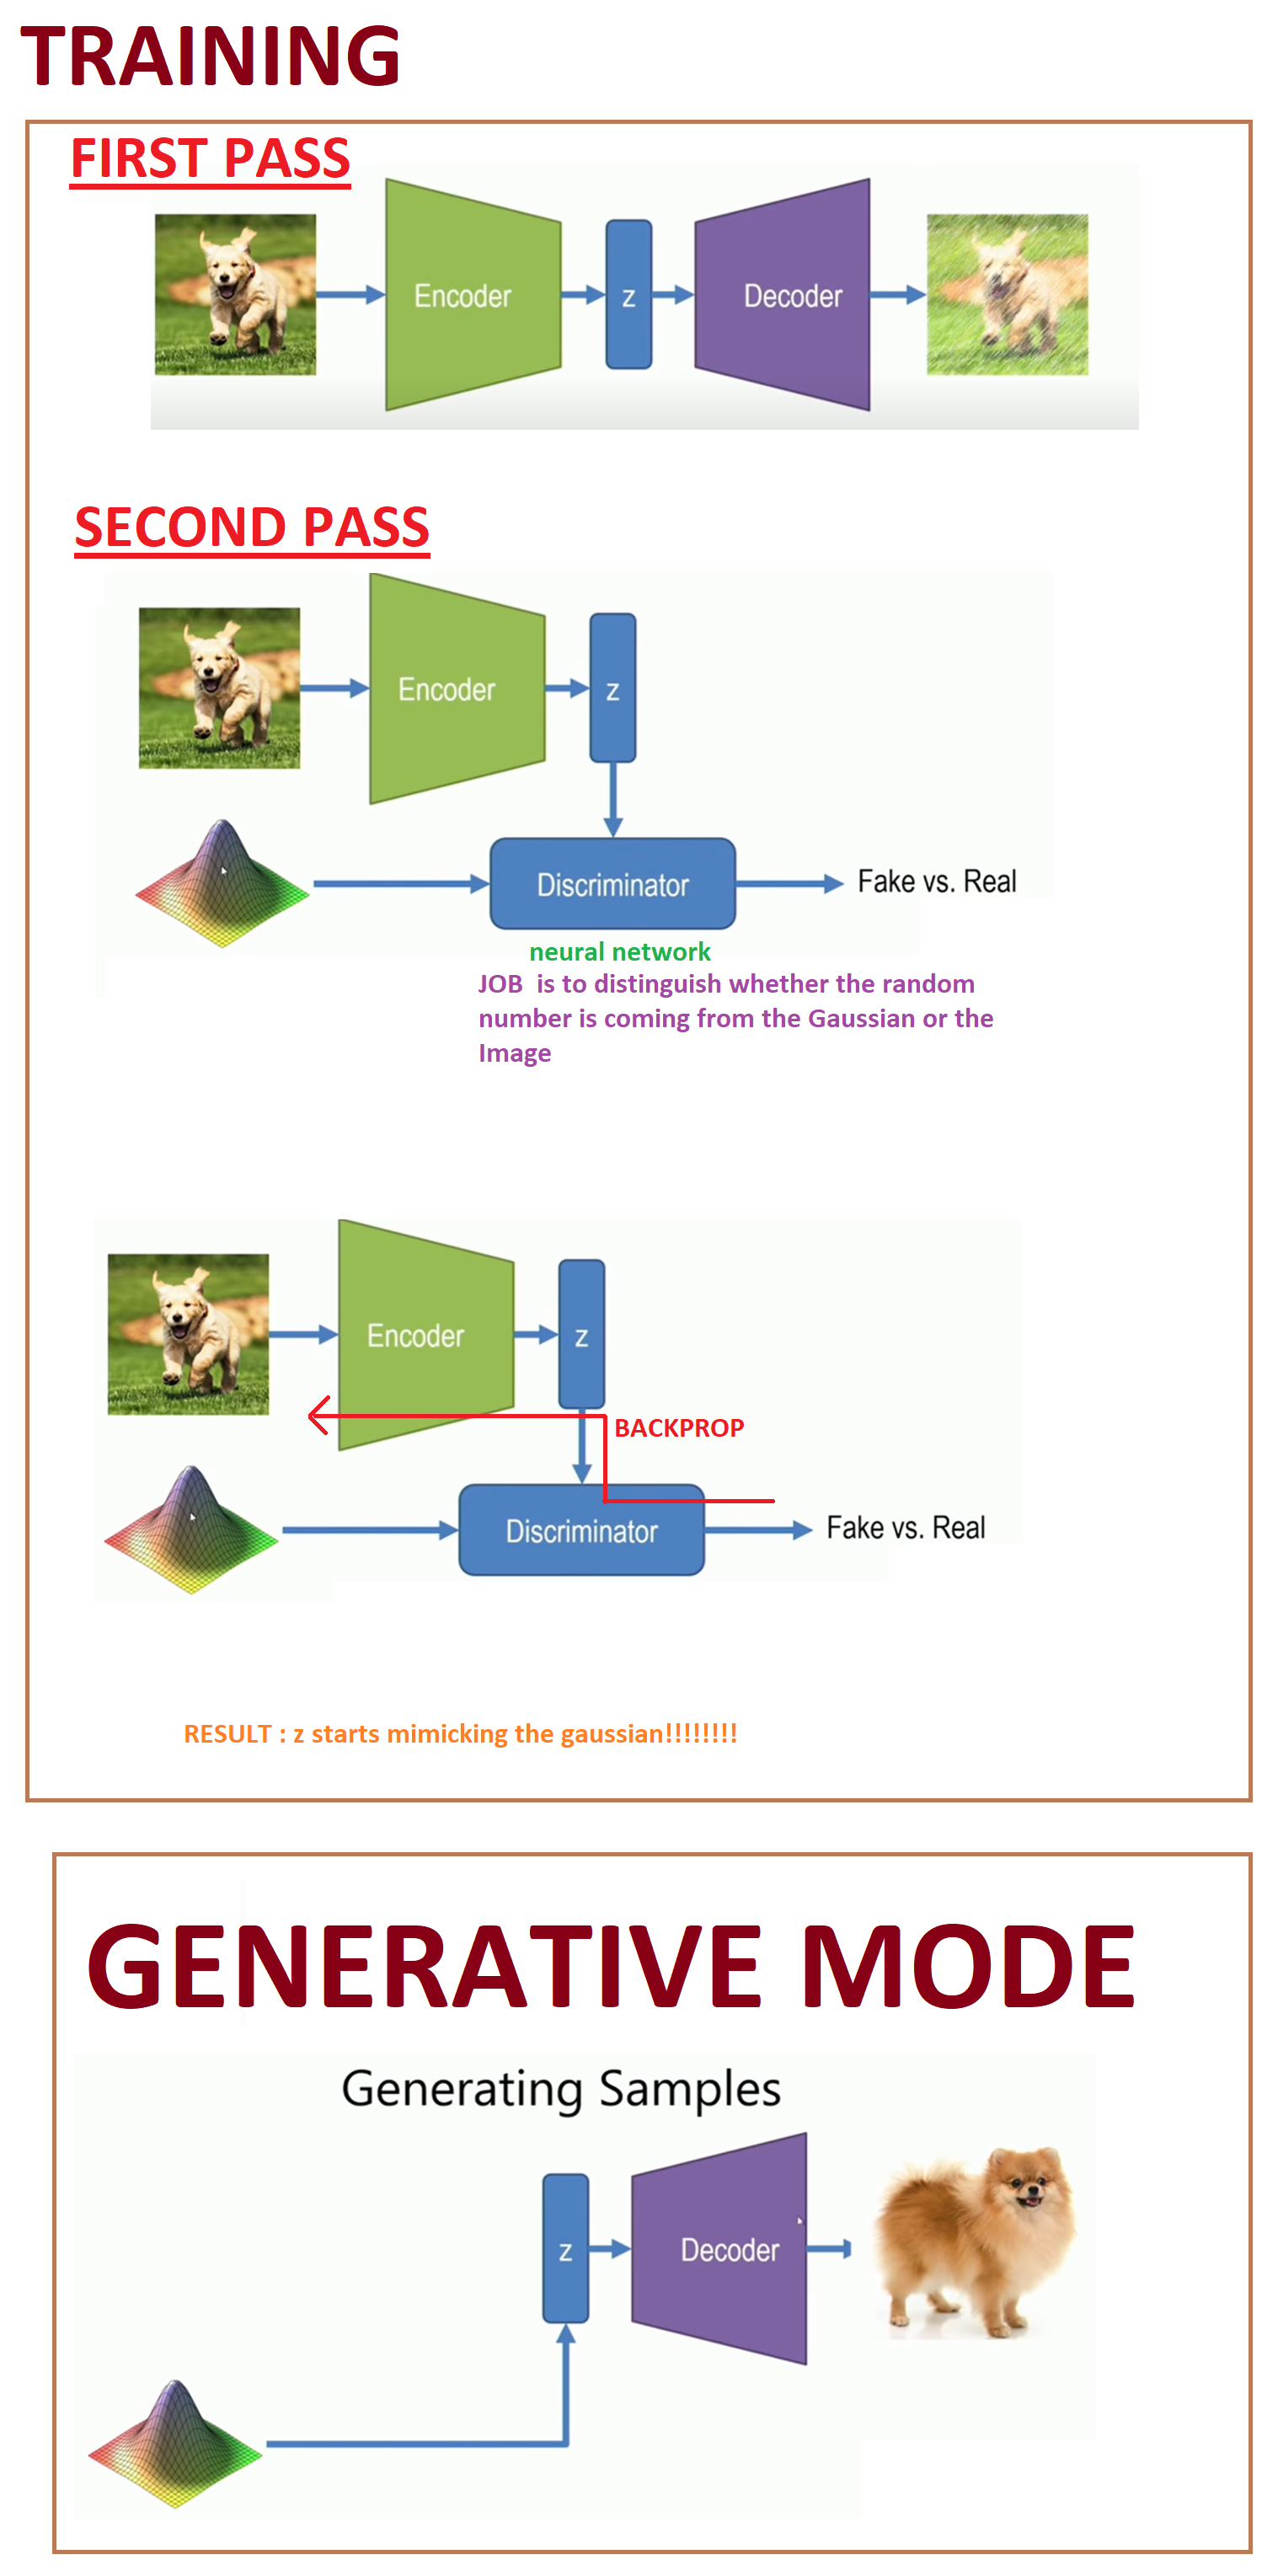

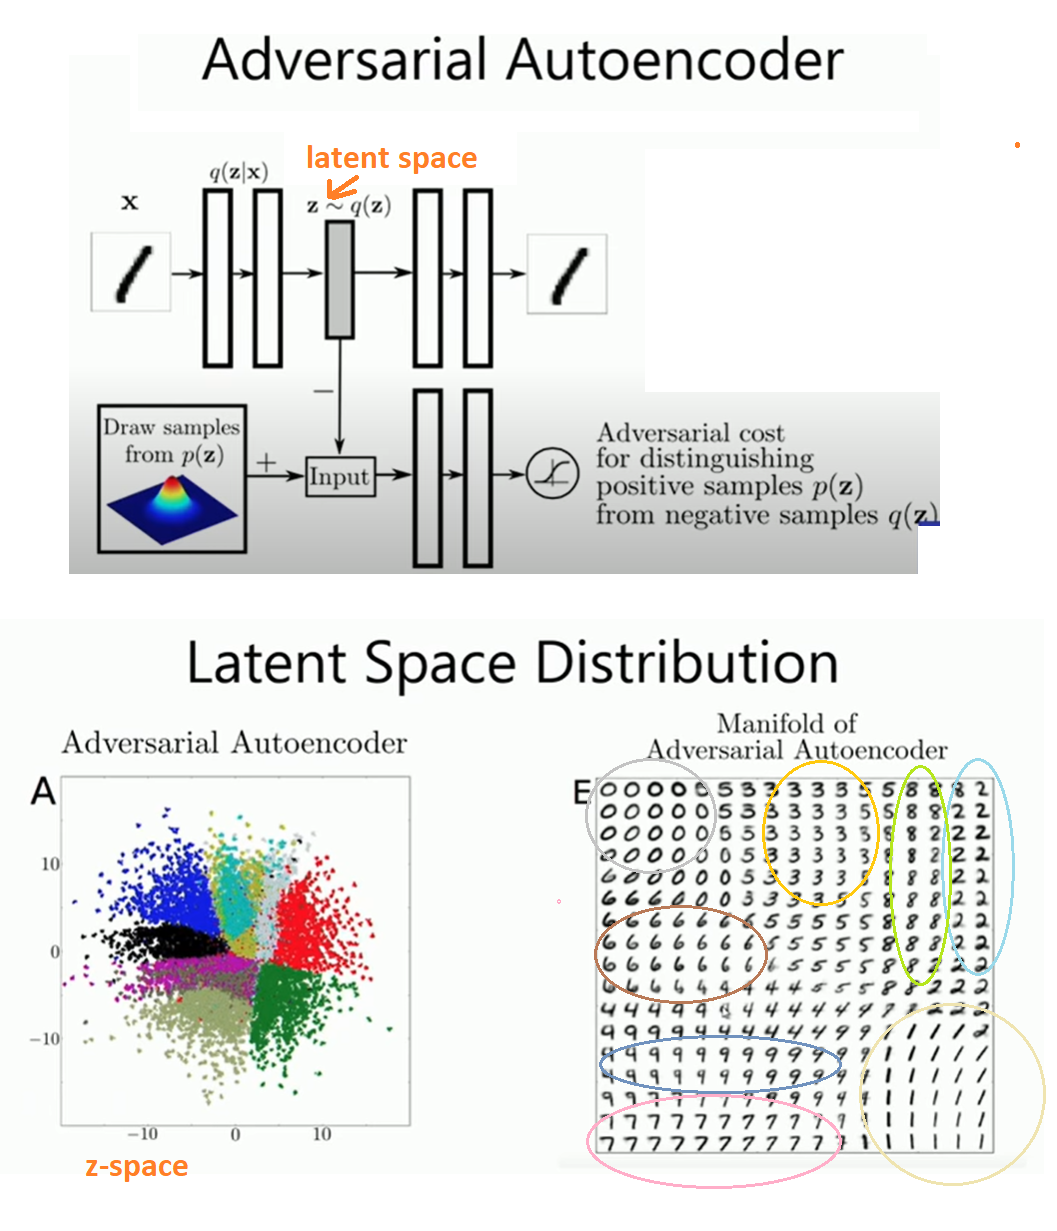

## Load Packages

In [1]:
%matplotlib inline
import os
import math
import torch
import itertools
import torch.nn as nn
import torch.optim as optim
from IPython import display
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.datasets as dsets
import torchvision.transforms as transforms

print(torch.__version__) # This code has been updated for PyTorch 1.0.0

1.5.0


## Load Data

In [28]:
# MNIST Dataset 
dataset = dsets.MNIST(root='./MNIST', train=True, transform=transforms.ToTensor(),  download=True)
testset = dsets.MNIST(root='./MNIST', train=False, transform=transforms.ToTensor(),  download=True)

# Data Loader (Input Pipeline)
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=50, shuffle=False)

In [29]:
# Check availability of GPU

use_gpu = torch.cuda.is_available()
# use_gpu = False # Uncomment in case of GPU memory error
if use_gpu:
    print('GPU is available!')
    device = "cuda"
else:
    print('GPU is not available!')
    device = "cpu"

GPU is available!


## Defining network architecture

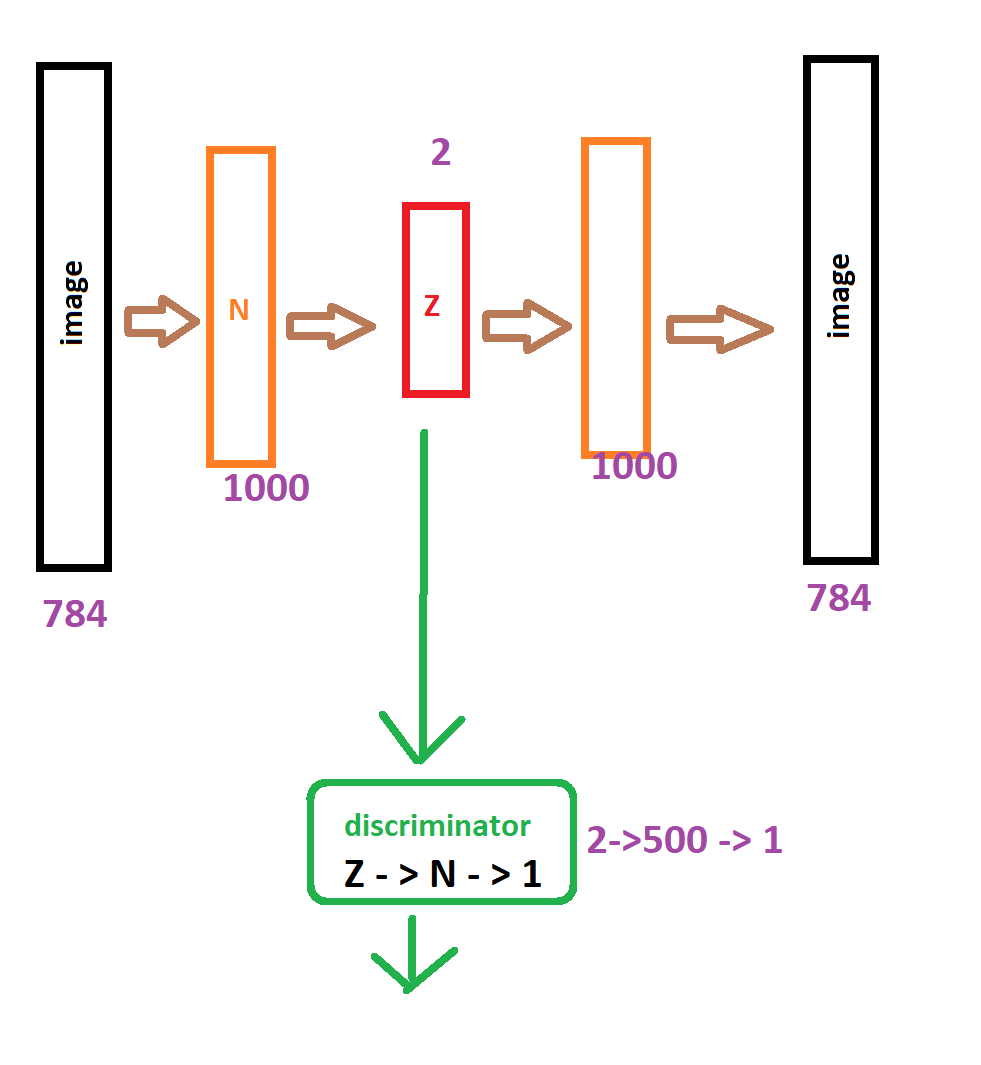

<b>Encoder : </b> <br>
<b> X_dim -> N -> Z </b>

<br>
Z = Bottle Neck Layer( Latent Variable)

In [13]:
#Encoder
class Q_net(nn.Module):  
    
    def __init__(self,X_dim, N, z_dim):
        super(Q_net, self).__init__()
        self.lin1 = nn.Linear(X_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3gauss = nn.Linear(N, z_dim)  #later we'll try to make this varibale mimik a gaussian
    
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.25, training=self.training) #helps prevent overfitting
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.25, training=self.training)
        x = F.relu(x)
        #Note: Dropout included here (Latent varibale should not have dropout)
                                      #if dropout is included peaks would  be produced in the distribution, skews the distribution
        xgauss = self.lin3gauss(x)
        return xgauss

<b>Decoder : </b> <br>
<b> Z -> N -> X_dim</b>

In [14]:
# Decoder
class P_net(nn.Module):  
    def __init__(self,X_dim, N, z_dim):
        super(P_net, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, X_dim)
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.25, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.25, training=self.training)
        x = self.lin3(x)
        return torch.sigmoid(x)  #output = (0,1)

In [15]:
#Discriminator
class D_net_gauss(nn.Module):  
    def __init__(self,N,z_dim):  #N = number of neurons in the discriminator
        super(D_net_gauss, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, 1)
        
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = F.relu(x)
        return F.sigmoid(self.lin3(x))

## Define optimizer

In [16]:
z_red_dims = 2  #Latnest SPce Dimensions

In [17]:
Q = Q_net(784,1000,z_red_dims).to(device)         # 784 -> 1000 - > 2
P = P_net(784,1000,z_red_dims).to(device)         #2-1000 -> 784
D_gauss = D_net_gauss(500,z_red_dims).to(device)  #2->500->1

In [18]:
# Set learning rates
gen_lr = 0.0001
reg_lr = 0.00005

In [ ]:
#encode/decode optimizers
optim_P = optim.Adam(P.parameters(), lr=gen_lr)
optim_Q_enc = optim.Adam(Q.parameters(), lr=gen_lr)
#regularizing optimizers
optim_Q_gen = optim.Adam(Q.parameters(), lr=reg_lr)
optim_D = optim.Adam(D_gauss.parameters(), lr=reg_lr)

## Test Data

In [19]:
num_test_samples = 100

test_noise = torch.Tensor(num_test_samples,z_red_dims)
p = [-1,1,-1,1]
q = [-1,1,1,-1]
for loop in range(4):
    
    for i in range(5):
        for j in range(5):
            test_noise[25*loop+i*5+j] = torch.Tensor([(i+1)*0.4*p[loop], (j+1)*0.4*q[loop]])

## Training

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 2.00 GiB total capacity; 22.58 MiB already allocated; 10.19 MiB free; 26.00 MiB reserved in total by PyTorch) (malloc at ..\c10\cuda\CUDACachingAllocator.cpp:289)
(no backtrace available)

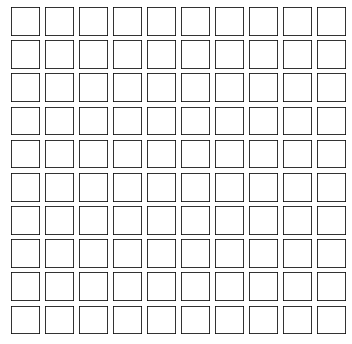

In [33]:
# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
    
    

data_iter = iter(data_loader)
iter_per_epoch = len(data_loader)
total_step = 5000

# Start training
for step in range(total_step):

    # Reset the data_iter
    if (step+1) % iter_per_epoch == 0:
        data_iter = iter(data_loader)

    # Fetch the images and labels and convert them to variables
    images, labels = next(data_iter)
    images, labels = images.view(images.size(0), -1).to(device), labels.to(device)

    #reconstruction loss
    P.zero_grad()
    Q.zero_grad()
    D_gauss.zero_grad()

    z_sample = Q(images)   #encode to z
    X_sample = P(z_sample) #decode to X reconstruction
    recon_loss = F.binary_cross_entropy(X_sample,images)

    recon_loss.backward()
    optim_P.step()
    optim_Q_enc.step()

    # Discriminator
    ## true prior is random normal (randn)
    ## this is constraining the Z-projection to be normal!
    Q.eval()  #Encoder  
    z_real_gauss = torch.randn(images.size()[0], z_red_dims).to(device)  #random number from a gaussian
    D_real_gauss = D_gauss(z_real_gauss)  #pass rnd. numb. through discriminator

    z_fake_gauss = Q(images)  #pass image through encoder
    D_fake_gauss = D_gauss(z_fake_gauss)  #pass encoder output to discriminator

    D_loss = -torch.mean(torch.log(D_real_gauss) + torch.log(1 - D_fake_gauss))

    D_loss.backward()  
    optim_D.step()   #update disciminator

    # Generator
    Q.train()
    z_fake_gauss = Q(images)
    D_fake_gauss = D_gauss(z_fake_gauss)
    
    G_loss = -torch.mean(torch.log(D_fake_gauss))

    G_loss.backward()
    optim_Q_gen.step()   
    
    P.eval()
    test_images = P(test_noise.to(device))
    P.train()
    if use_gpu:
            test_images = test_images.cpu().detach()
    for k in range(num_test_samples):
        i = k//10
        j = k%10
        ax[i,j].cla()        
        ax[i,j].imshow(test_images[k,:].numpy().reshape(28, 28), cmap='Greys')
    display.clear_output(wait=True)
    display.display(plt.gcf())    

#  Adversarial Autoencoder for Classification

- Using the trained Encoder of the the Adversial AutoEncoder to creatatee richer features 

## Load Packages

In [2]:
%matplotlib inline
import os
import math
import torch
import itertools
import torch.nn as nn
import torch.optim as optim
from IPython import display
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.datasets as dsets
import torchvision.transforms as transforms

print(torch.__version__) # This code has been updated for PyTorch 1.0.0

OSError: [WinError 1455] The paging file is too small for this operation to complete

## Load Data

In [35]:
# MNIST Dataset 
dataset = dsets.MNIST(root='./MNIST', train=True, transform=transforms.ToTensor(),  download=True)
testset = dsets.MNIST(root='./MNIST', train=False, transform=transforms.ToTensor(),  download=True)

# Data Loader (Input Pipeline)
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=100, shuffle=False)

In [36]:
# Check availability of GPU

use_gpu = torch.cuda.is_available()
# use_gpu = False # Uncomment in case of GPU memory error
if use_gpu:
    print('GPU is available!')
    device = "cuda"
else:
    print('GPU is not available!')
    device = "cpu"

GPU is available!


## Defining network architecture

In [ ]:
#Encoder
class Q_net(nn.Module):  
    def __init__(self,X_dim,N,z_dim):
        super(Q_net, self).__init__()
        self.lin1 = nn.Linear(X_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3gauss = nn.Linear(N, z_dim)
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.25, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.25, training=self.training)
        x = F.relu(x)
        x = self.lin3gauss(x)
        return x

# Decoder
class P_net(nn.Module):  
    def __init__(self,X_dim,N,z_dim):
        super(P_net, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, X_dim)
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.25, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.25, training=self.training)
        x = self.lin3(x)
        return torch.sigmoid(x)

# Discriminator
class D_net_gauss(nn.Module):  
    def __init__(self,N,z_dim):
        super(D_net_gauss, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, 1)
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = F.relu(x)
        return torch.sigmoid(self.lin3(x))   

## Define optimizer

In [ ]:
z_red_dims = 100  #LATENT VARIABLE DIMENSION
Q = Q_net(784,1000,z_red_dims).to(device)
P = P_net(784,1000,z_red_dims).to(device)
D_gauss = D_net_gauss(500,z_red_dims).to(device)

In [ ]:
# Set learning rates
gen_lr = 0.0001
reg_lr = 0.00005

In [ ]:
#encode/decode optimizers
optim_P = optim.Adam(P.parameters(), lr=gen_lr)
optim_Q_enc = optim.Adam(Q.parameters(), lr=gen_lr)
#regularizing optimizers
optim_Q_gen = optim.Adam(Q.parameters(), lr=reg_lr)
optim_D = optim.Adam(D_gauss.parameters(), lr=reg_lr)

## Test Data

In [ ]:
num_test_samples = 100

test_noise = torch.randn(num_test_samples,z_red_dims).to(device)  #since Z is 100 dimensional

## Training

In [ ]:
# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
    
    
data_iter = iter(data_loader)
iter_per_epoch = len(data_loader)
total_step = 5#5000

# Start training
for step in range(total_step):

    # Reset the data_iter
    if (step+1) % iter_per_epoch == 0:
        data_iter = iter(data_loader)

    # Fetch the images and labels and convert them to variables
    images, labels = next(data_iter)
    images, labels = images.view(images.size(0), -1).to(device), labels.to(device)

    #reconstruction loss
    P.zero_grad()
    Q.zero_grad()
    D_gauss.zero_grad()

    z_sample = Q(images)   #encode to z
    X_sample = P(z_sample) #decode to X reconstruction
    recon_loss = F.binary_cross_entropy(X_sample,images)  #since range = (0,1)

    recon_loss.backward()
    optim_P.step()
    optim_Q_enc.step()

    # Discriminator
    ## true prior is random normal (randn)
    ## this is constraining the Z-projection to be normal!
    Q.eval()
    z_real_gauss = torch.randn(images.size()[0], z_red_dims).to(device)
    D_real_gauss = D_gauss(z_real_gauss)

    z_fake_gauss = Q(images)
    D_fake_gauss = D_gauss(z_fake_gauss)

    D_loss = -torch.mean(torch.log(D_real_gauss) + torch.log(1 - D_fake_gauss))

    D_loss.backward()
    optim_D.step()

    # Generator
    Q.train()
    z_fake_gauss = Q(images)
    D_fake_gauss = D_gauss(z_fake_gauss)
    
    G_loss = -torch.mean(torch.log(D_fake_gauss))

    G_loss.backward()
    optim_Q_gen.step()   
    
    P.eval()
    test_images = P(test_noise)
    P.train()
    if use_gpu:
        test_images = test_images.cpu().detach()
            
    for k in range(num_test_samples):
        i = k//10
        j = k%10
        ax[i,j].cla()
        ax[i,j].imshow(test_images[k,:].numpy().reshape(28, 28), cmap='Greys')
    display.clear_output(wait=True)
    display.display(plt.gcf())    

## Classifier

- Using the encoder

In [3]:
#Encoder
class Classifier(nn.Module):  
    def __init__(self):
        super(Classifier, self).__init__()
        self.l1 = Q
        self.l2 = nn.Linear(100,10)
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        return x

NameError: name 'nn' is not defined

In [ ]:
net = Classifier().to(device)
print(net)

In [ ]:
criterion = nn.CrossEntropyLoss()  #since one-hot target
optimizer = optim.Adam(net.parameters(), lr=1e-4)

## Training

In [ ]:
iterations = 10

for epoch in range(iterations):  # loop over the dataset multiple times

    runningLoss = 0.0
    for i, data in enumerate(data_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.view(inputs.size(0), -1).to(device), labels.to(device)
        
        net.train()
        optimizer.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() #  backpropagate the loss
        optimizer.step()
    correct = 0
    total = 0
    net.eval()    ###TESTING########
    with torch.no_grad():
        for data in test_loader:        
            inputs, labels = data
            inputs, labels = inputs.view(inputs.size(0), -1).to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.data).sum()
    print('At Iteration : %d / %d  ;Test Accuracy : %f'%(epoch + 1,iterations,100 * float(correct) /float(total)))
print('Finished Training')

# Adversarial Autoencoder with Regularization

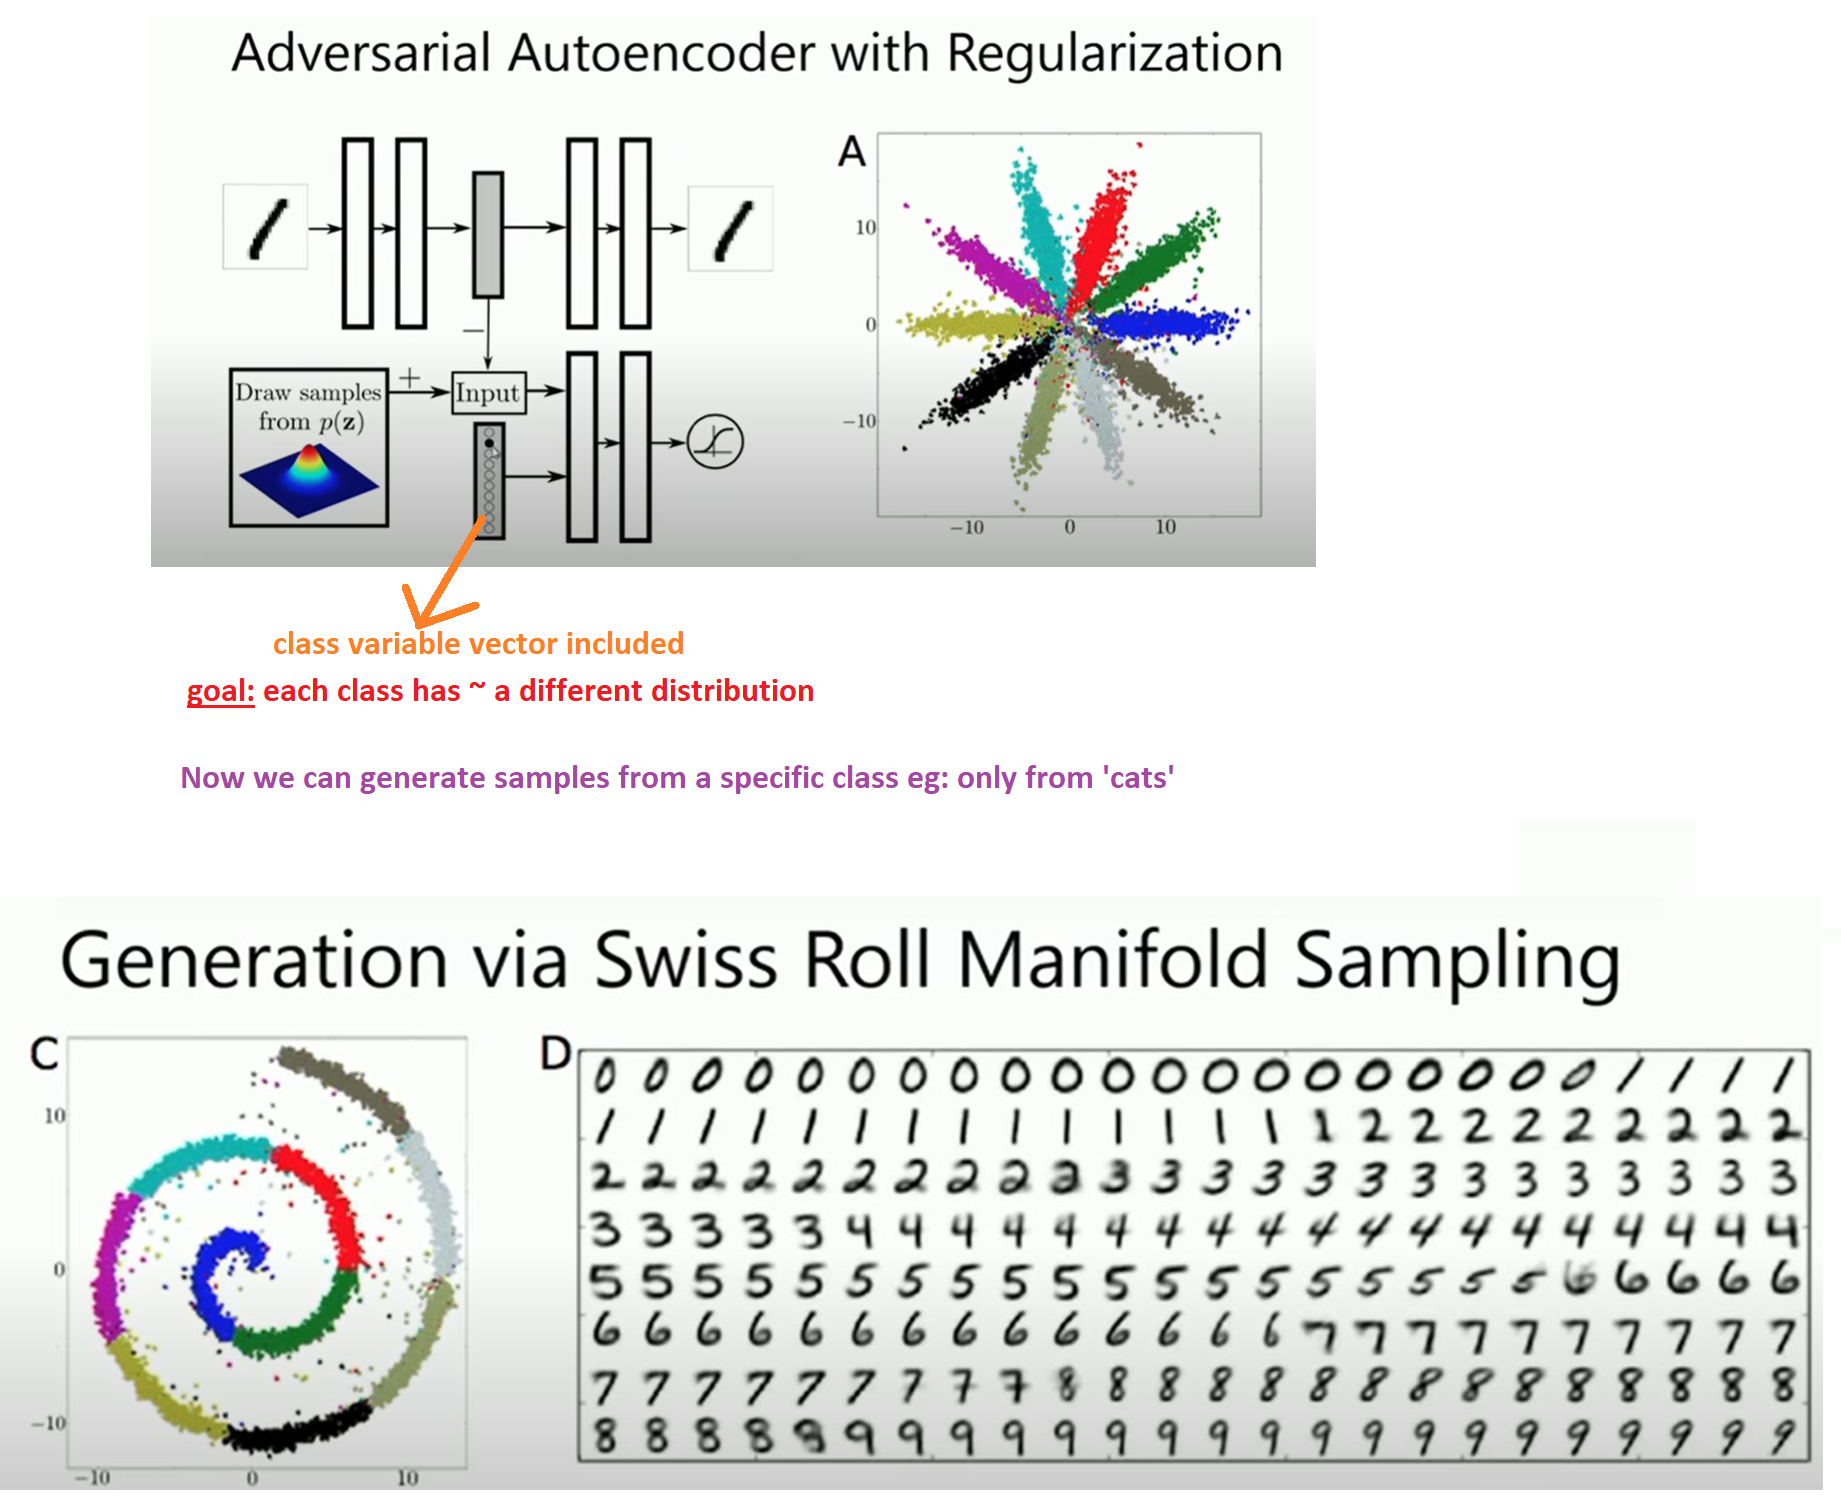

# Supervised Adversarial Autoencoder

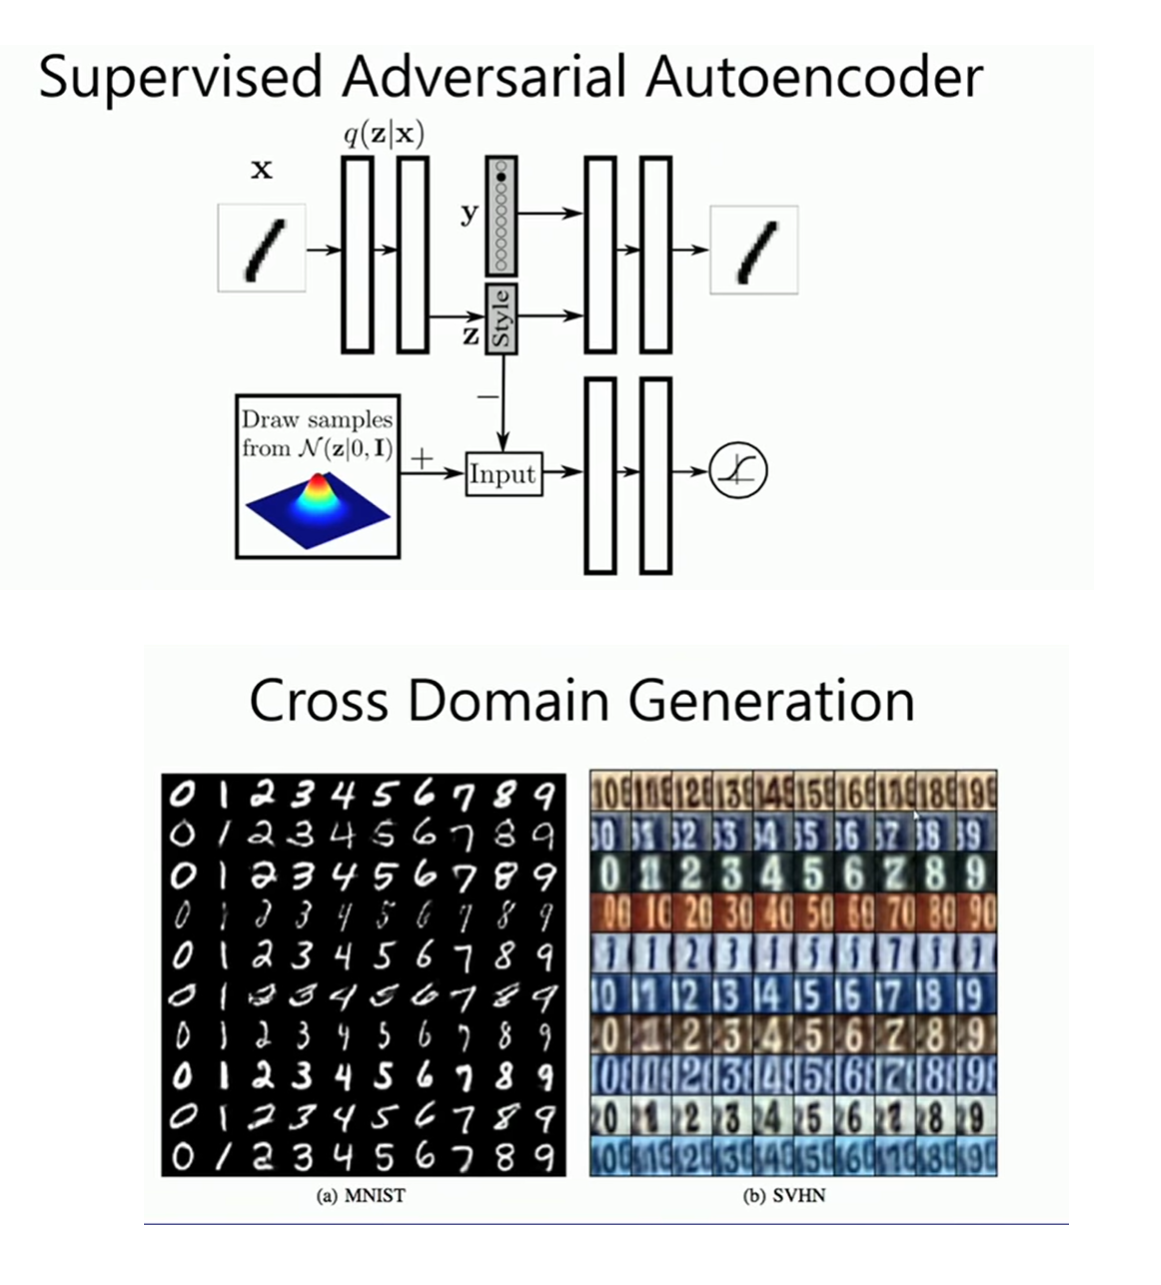